In [76]:
import os
import mlflow
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.regression import *
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Supress warnings
warnings. filterwarnings('ignore')

%matplotlib inline

In [2]:
DATA_DIR = "dataset"

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

train.head()

Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   Current Loan Expenses (USD) Expense Type 1 Expense Type 2  Dependents  \
0                       241.08              N              N         3.0   
1                       495.81              N              Y         1.0   
2                       171.95              N              Y         1.0   
3                       298.54              N              Y         2.0   
4                       491.41              N              Y         NaN   

   Credit Score  No. of Defaults Has Active Credit Card  Property ID  \
0        809.44                0                    NaN          746   
1        780.40                0            Unpossessed          608   
2        833.15                0            Unpossessed          546   
3        832.70                1            Unpossessed          890   
4        745.55                1                 Active          715   

   Property Age  Property Type Property Location  Co-Applicant  \
0       1933.05              4             Rural             1   
1       4952.91              2             Rural             1   
2        988.19              2             Urban             0   
3           NaN              2        Semi-Urban             1   
4       2614.77              4        Semi-Urban             1   

   Property Price  Loan Sanction Amount (USD)  
0       119933.46                    54607.18  
1        54791.00                    37469.98  
2        72440.58                    36474.43  
3       121441.51                    56040.54  
4       208567.91                    74008.28

## EDA

In [74]:
# Identify the missing values in the data
missing_values = train.isnull().sum()

pd.DataFrame(
    [missing_values, round(missing_values * 100 / train.shape[0], 2)],
    index=["Missing Values", "Missing Values (%)"],
).T

Missing Values  Missing Values (%)
Customer ID                             0.0                0.00
Name                                    0.0                0.00
Gender                                 53.0                0.18
Age                                     0.0                0.00
Income (USD)                         4533.0               15.11
Income Stability                     1668.0                5.56
Profession                              0.0                0.00
Type of Employment                   7231.0               24.10
Location                                0.0                0.00
Loan Amount Request (USD)               0.0                0.00
Current Loan Expenses (USD)           171.0                0.57
Expense Type 1                          0.0                0.00
Expense Type 2                          0.0                0.00
Dependents                           2475.0                8.25
Credit Score                         1689.0                5.63
No. of Defaults                         0.0                0.00
Has Active Credit Card               1555.0                5.18
Property ID                             0.0                0.00
Property Type                           0.0                0.00
Property Location                     354.0                1.18
Co-Applicant                            0.0                0.00
Property Price                          0.0                0.00
Loan Sanction Amount (USD)            337.0                1.12

In [29]:
# Dropping the rows where target values in null 
train = train.dropna(axis=0, subset=["Loan Sanction Amount (USD)"])
train.isnull().sum()

Customer ID                       0
Name                              0
Gender                           52
Age                               0
Income (USD)                   4493
Income Stability               1658
Profession                        0
Type of Employment             7188
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     167
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2446
Credit Score                   1670
No. of Defaults                   0
Has Active Credit Card         1546
Property ID                       0
Property Age                   4760
Property Type                     0
Property Location               347
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)        0
dtype: int64

In [4]:
# Basic EDA using pandas profiling
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)

profile.to_file("Loan Sanction Amount Analysis EDA report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


In [5]:
profile.to_widgets()

In [11]:
# Looking at correlation values based on column "Current Loan Expenses (USD)"
train.corr()["Current Loan Expenses (USD)"]

Age                           -0.023684
Income (USD)                   0.055080
Loan Amount Request (USD)      0.682248
Current Loan Expenses (USD)    1.000000
Dependents                     0.045300
Credit Score                   0.114950
No. of Defaults                0.002767
Property ID                   -0.014519
Property Age                   0.054682
Property Type                  0.014812
Co-Applicant                   0.002130
Property Price                 0.648636
Loan Sanction Amount (USD)     0.485070
Name: Current Loan Expenses (USD), dtype: float64

**Based on the EDA Reports, It is noticed that:**

-----------------------------------------------------

**Age:**

1. It is highly correlated with `Income stability`
2. We have age data from 18 to 65, Interestingly loan requested by age group 18 is `around 15%`. 60+ Age group (60-65) is around 10%
3. Correlation of Age with target variable is Low (~0.8%)

**Income (USD)**

1. Income (USD) is linearly realted to `Propery Age` (1). So dropping the `Propery Age` column from the data 
2. Highly Skewed data

**Loan Amount Request (USD)**

1. Highly correlated with `Property Price` (~0.95), `Current Loan Expenses (USD)` (0.68) and target variable `Loan Sanction Amount (USD)` (~0.72)
2. Left Skewed data

**Current Loan Expenses (USD)**

1. Contains Negative values in the data
2. Highly correlated with `Property Price` (~0.65) and `Loan Amount Request (USD)` (~0.68)

**Co-Application**

1. Has Negative value (-999) -> assuming data entry issue converting it into replace it with frequent group (1)

In [28]:
# Based on EDA modifing the training data
train = train.drop("Property Age", axis = 1)
train[train["Co-Applicant"] == -999] = 1

In [31]:
train["Co-Applicant"].unique()

array([1, 0])

### Categorical Variable Analysis

In [21]:
cat_columns = [col for col in train.columns if train[col].dtypes == "object"]
cat_columns

['Customer ID',
 'Name',
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']

In [28]:
# Unique value info 

print(f"Total Number of rows in the data:{train.shape[0]}")
print("----------------------------------------------------")
for col in cat_columns:
    print(f"Value of the column {col} is: {train[col].nunique()}")
    if train[col].nunique() < 20:
        print(f"Unique values in the column are: {train[col].unique()}\n\n")

Total Number of rows in the data:30000
----------------------------------------------------
Value of the column Customer ID is: 30000
Value of the column Name is: 30000
Value of the column Gender is: 2
Unique values in the column are: ['F' 'M' nan]


Value of the column Income Stability is: 2
Unique values in the column are: ['Low' 'High' nan]


Value of the column Profession is: 8
Unique values in the column are: ['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


Value of the column Type of Employment is: 18
Unique values in the column are: ['Sales staff' nan 'High skill tech staff' 'Secretaries' 'Laborers'
 'Managers' 'Cooking staff' 'Core staff' 'Drivers' 'Realty agents'
 'Security staff' 'Accountants' 'Private service staff'
 'Waiters/barmen staff' 'Medicine staff' 'Cleaning staff'
 'Low-skill Laborers' 'HR staff' 'IT staff']


Value of the column Location is: 3
Unique values in the column are: ['Semi-Urban' 'Rur

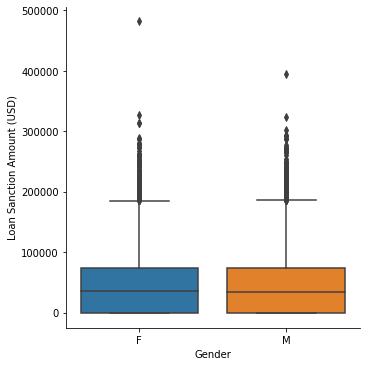

In [16]:
sns.catplot(x="Gender", y="Loan Sanction Amount (USD)", kind="box", data=train)

- Loan Sanction Amount is independent of Gender as avg value are same are both `Male` and `Female`

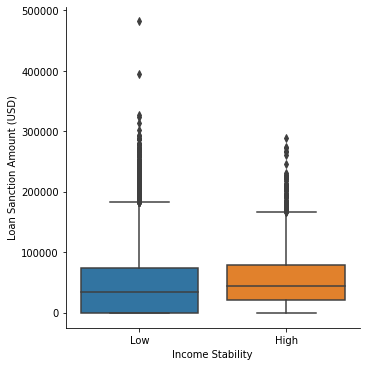

In [17]:
sns.catplot(x="Income Stability", y="Loan Sanction Amount (USD)", kind="box", data=train)

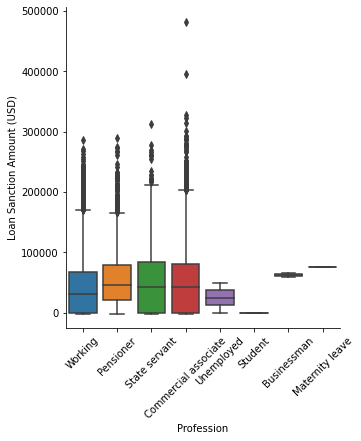

In [24]:
sns.catplot(x="Profession", y="Loan Sanction Amount (USD)", kind="box", data=train)
plt.xticks(rotation = 45)
plt.show()

It can be seen here loan amount sanctioned is higher for `Bussiness` group when compared to other Profession Groups

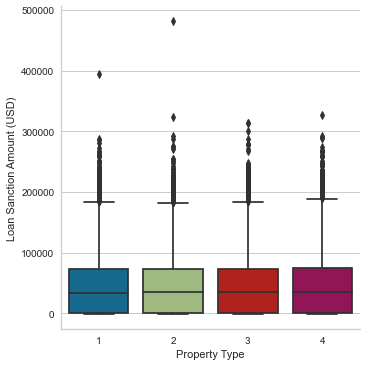

In [79]:
sns.catplot(x="Property Type", y="Loan Sanction Amount (USD)", kind="box", data=train)

In [37]:
train.corr()["Loan Sanction Amount (USD)"]

Age                            0.008112
Income (USD)                   0.038157
Loan Amount Request (USD)      0.726408
Current Loan Expenses (USD)    0.485070
Dependents                     0.009088
Credit Score                   0.369450
No. of Defaults               -0.004330
Property ID                   -0.009751
Property Age                   0.037796
Property Type                  0.001984
Co-Applicant                  -0.006945
Property Price                 0.687181
Loan Sanction Amount (USD)     1.000000
Name: Loan Sanction Amount (USD), dtype: float64

In [41]:
train.corr()

Age  Income (USD)  \
Age                          1.000000     -0.010124   
Income (USD)                -0.010124      1.000000   
Loan Amount Request (USD)   -0.010366      0.050101   
Current Loan Expenses (USD) -0.023535      0.055323   
Dependents                  -0.083553      0.005309   
Credit Score                 0.130812      0.012643   
No. of Defaults              0.003452     -0.002113   
Property ID                 -0.012820     -0.008126   
Property Age                -0.010256      1.000000   
Property Type                0.001463      0.009649   
Co-Applicant                 0.001577      0.000465   
Property Price              -0.010132      0.050419   
Loan Sanction Amount (USD)   0.008112      0.038157   

                             Loan Amount Request (USD)  \
Age                                          -0.010366   
Income (USD)                                  0.050101   
Loan Amount Request (USD)                     1.000000   
Current Loan Expenses (USD)                   0.682982   
Dependents                                    0.040790   
Credit Score                                  0.177298   
No. of Defaults                              -0.000114   
Property ID                                  -0.009390   
Property Age                                  0.049716   
Property Type                                 0.004043   
Co-Applicant                                  0.002188   
Property Price                                0.948553   
Loan Sanction Amount (USD)                    0.726408   

                             Current Loan Expenses (USD)  Dependents  \
Age                                            -0.023535   -0.083553   
Income (USD)                                    0.055323    0.005309   
Loan Amount Request (USD)                       0.682982    0.040790   
Current Loan Expenses (USD)                     1.000000    0.044630   
Dependents                                      0.044630    1.000000   
Credit Score                                    0.114298   -0.089930   
No. of Defaults                                 0.001949    0.008628   
Property ID                                    -0.016006    0.003057   
Property Age                                    0.054940    0.005210   
Property Type                                   0.015225   -0.009904   
Co-Applicant                                    0.002472    0.003518   
Property Price                                  0.649395    0.037363   
Loan Sanction Amount (USD)                      0.485070    0.009088   

                             Credit Score  No. of Defaults  Property ID  \
Age                              0.130812         0.003452    -0.012820   
Income (USD)                     0.012643        -0.002113    -0.008126   
Loan Amount Request (USD)        0.177298        -0.000114    -0.009390   
Current Loan Expenses (USD)      0.114298         0.001949    -0.016006   
Dependents                      -0.089930         0.008628     0.003057   
Credit Score                     1.000000         0.007061    -0.006613   
No. of Defaults                  0.007061         1.000000    -0.001879   
Property ID                     -0.006613        -0.001879     1.000000   
Property Age                     0.012692        -0.002055    -0.008053   
Property Type                    0.008271         0.000089     0.008987   
Co-Applicant                     0.010293        -0.007805     0.009389   
Property Price                   0.169913         0.001622    -0.012369   
Loan Sanction Amount (USD)       0.369450        -0.004330    -0.009751   

                             Property Age  Property Type  Co-Applicant  \
Age                             -0.010256       0.001463      0.001577   
Income (USD)                     1.000000       0.009649      0.000465   
Loan Amount Request (USD)        0.049716       0.004043      0.002188   
Current Loan Expenses (USD)      0.054940       0.015225      0.002472   
Dependents          

<AxesSubplot:>

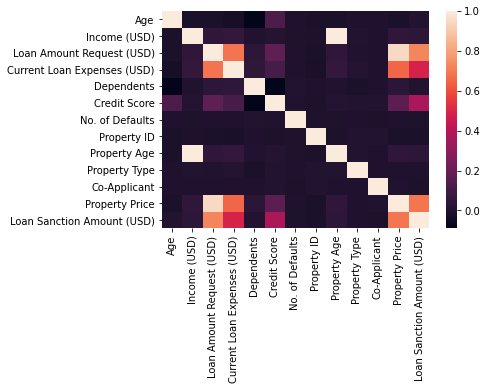

In [34]:
import seaborn as sns
numerical_cols = [col for col in train.columns if train[col].dtypes != "object"]
sns.heatmap(train.corr())

## Modelling

In [48]:
exp_reg = setup(
    data=train,
    target="Loan Sanction Amount (USD)",
    categorical_features=["Property Type", "Property ID"],
    high_cardinality_features=["Property ID"],
    ignore_features=["Customer ID", "Name"],
    remove_multicollinearity=True,
    multicollinearity_threshold=0.6,
    session_id=123,
    feature_interaction=True,
    experiment_name="Loan Sanction Amount Analysis",
    feature_ratio=True,
)

https://www.pycaret.org/tutorials/html/REG101.html

In [49]:
compare_models()

Based on the run, predictability of `catboost` model better compared to other models based on `r2`. So lets tune the parameters of catboost model to improve the `r2` value

In [51]:
cat = create_model('catboost')

In [54]:
tuned_cat = tune_model(cat, optimize="R2")

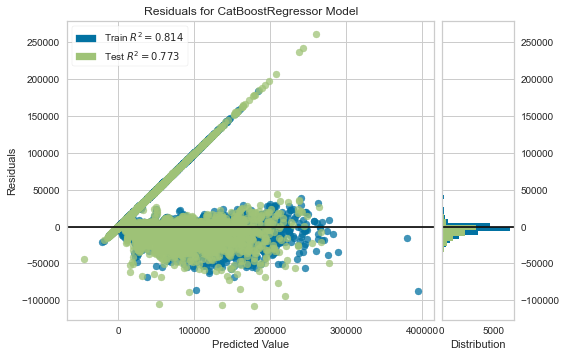

In [55]:
plot_model(tuned_cat)

In [56]:
evaluate_model(tuned_cat)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [60]:
final_cat = finalize_model(tuned_cat)

## Predict on unseen data

In [61]:
test = test.drop("Property Age", axis = 1)

test[test["Co-Applicant"] == -999] = 1

In [66]:
import numpy as np
test[test=="?"] = np.nan

In [67]:
unseen_predictions = predict_model(final_cat, data=test)
unseen_predictions.head()

Customer ID              Name Gender  Age  Income (USD) Income Stability  \
0     C-26247  Tandra Olszewski      F   47       3472.69              Low   
1     C-35067     Jeannette Cha      F   57       1184.84              Low   
2     C-34590      Keva Godfrey      F   52       1266.27              Low   
3     C-16668      Elva Sackett      M   65       1369.72             High   
4     C-12196    Sade Constable      F   60       1939.23             High   

             Profession Type of Employment    Location  \
0  Commercial associate           Managers  Semi-Urban   
1               Working        Sales staff       Rural   
2               Working                NaN  Semi-Urban   
3             Pensioner                NaN       Rural   
4             Pensioner                NaN       Urban   

   Loan Amount Request (USD)  ...  Dependents Credit Score No. of Defaults  \
0                  137088.98  ...         2.0       799.14               0   
1                  104771.59  ...         2.0       833.31               0   
2                  176684.91  ...         3.0       627.44               0   
3                   97009.18  ...         2.0       833.20               0   
4                  109980.00  ...         NaN          NaN               0   

   Has Active Credit Card  Property ID  Property Type Property Location  \
0             Unpossessed          843              2             Urban   
1             Unpossessed           22              1             Rural   
2             Unpossessed            1              1             Urban   
3                Inactive          730              1        Semi-Urban   
4                     NaN          356              4        Semi-Urban   

   Co-Applicant  Property Price         Label  
0             1        236644.5  90056.125588  
1             1        142357.3  65894.539457  
2             1       300991.24   8276.638048  
3             0        125612.1  54216.576076  
4             1        180908.0  70415.056833  

[5 rows x 23 columns]

In [71]:
submission_df = unseen_predictions[["Customer ID", "Label"]]
submission_df.rename(columns={"Label": "Loan Sanction Amount (USD)"}, inplace=True)
submission_df.to_csv("submission_file_cat_initial.csv", index=False)

In [72]:
submission_df.head()

Customer ID  Loan Sanction Amount (USD)
0     C-26247                90056.125588
1     C-35067                65894.539457
2     C-34590                 8276.638048
3     C-16668                54216.576076
4     C-12196                70415.056833